# Introduction

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

We are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. [The dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. The dataset has the following features:

* `Age`: age of the patient [years]
* `Sex`: sex of the patient [M: Male, F: Female]
* `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* `RestingBP`: resting blood pressure [mm Hg]
* `Cholesterol`: serum cholesterol [mm/dl]
* `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
* `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
* `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
* `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* `HeartDisease`: output class [1: heart disease, 0: Normal]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/heart_disease_prediction.csv')
print(df.head(2))
print(df.info())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9 

## First Views

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Key points:

* Average age of `53 years`
* The median for `Cholesterol` is higher than its mean by roughly `25 mm/dl`, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
* `RestingBP` and `Cholesterol` have a minimum value of zero, which does not make sense.
* There aren't missing values


In [6]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [7]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.union(['HeartDisease', 'FastingBS'])

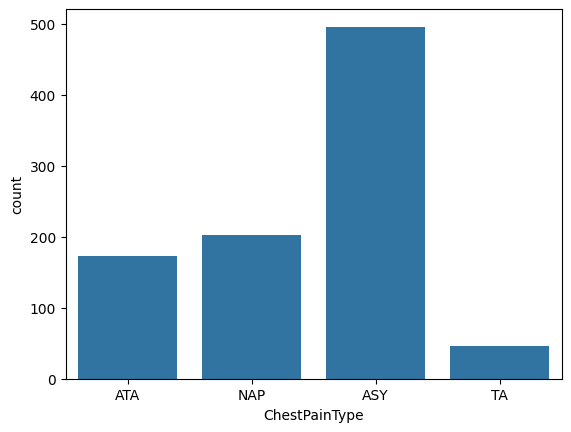

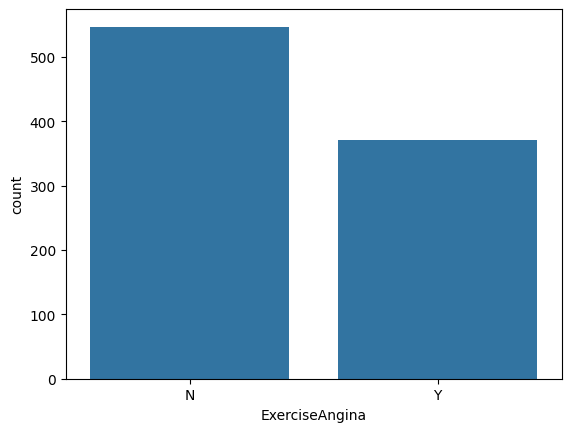

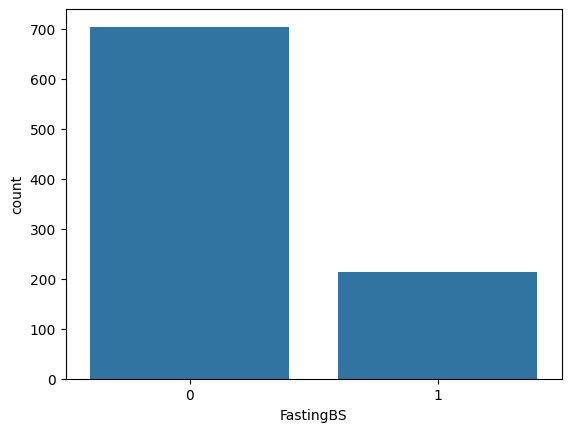

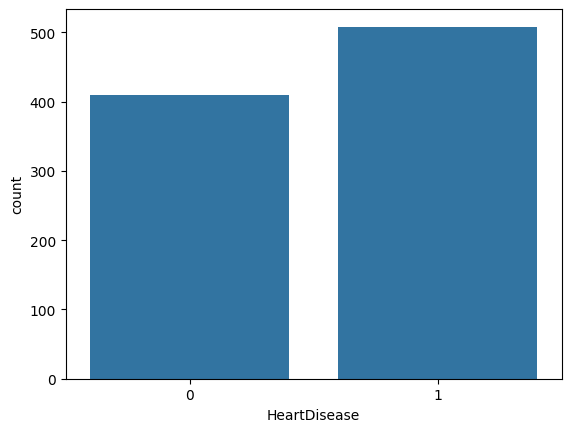

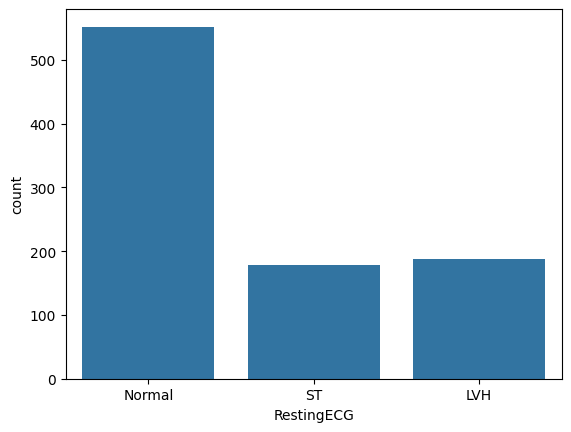

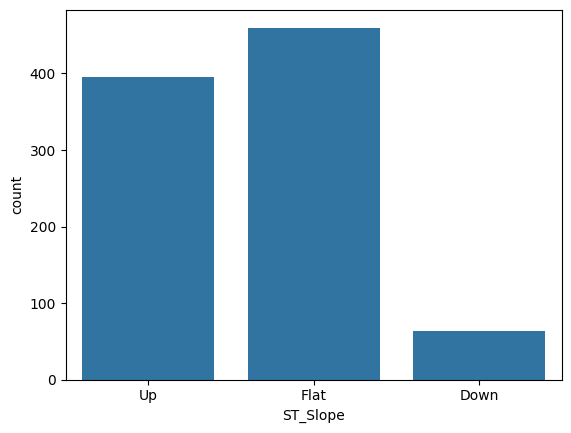

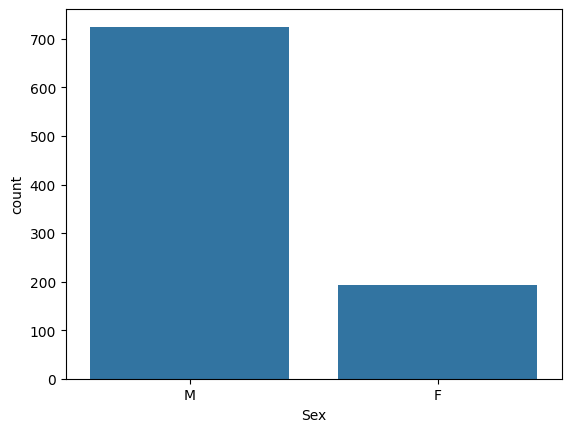

In [8]:
for i in categorical_columns:
  plt.figure()
  sns.countplot(data=df, x=i)

In the dataset, we have a male majority, heart disease majority and an ASY chest pain type majority.

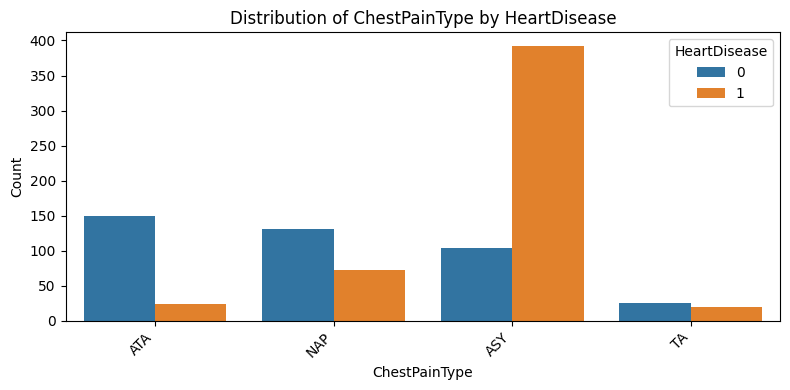

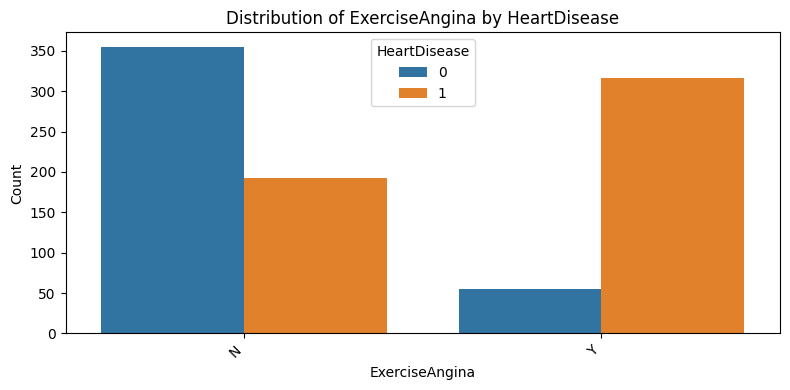

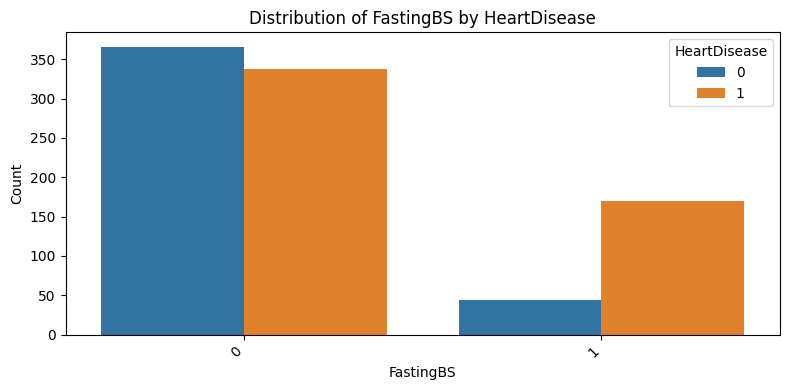

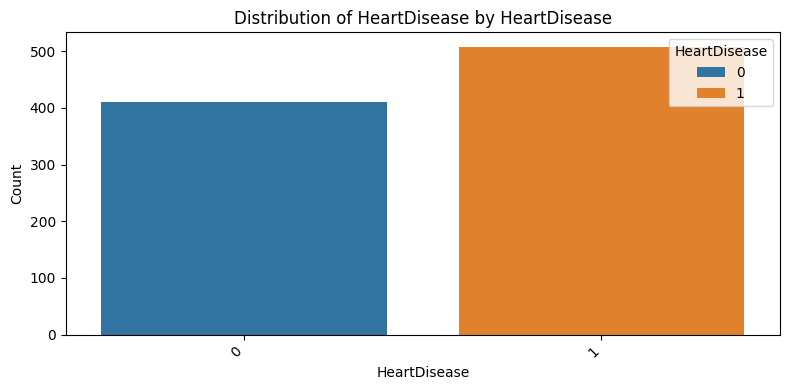

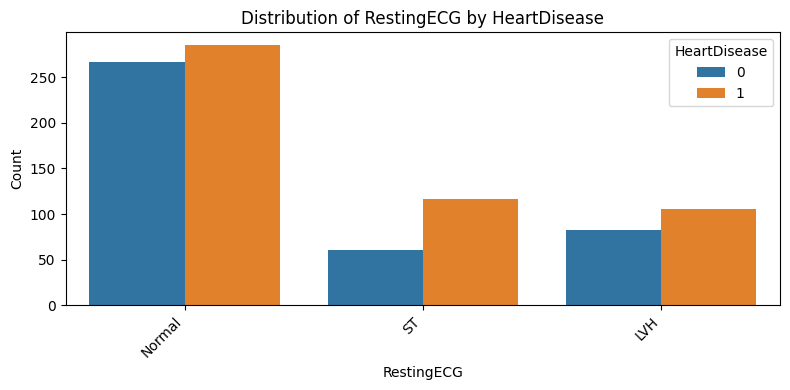

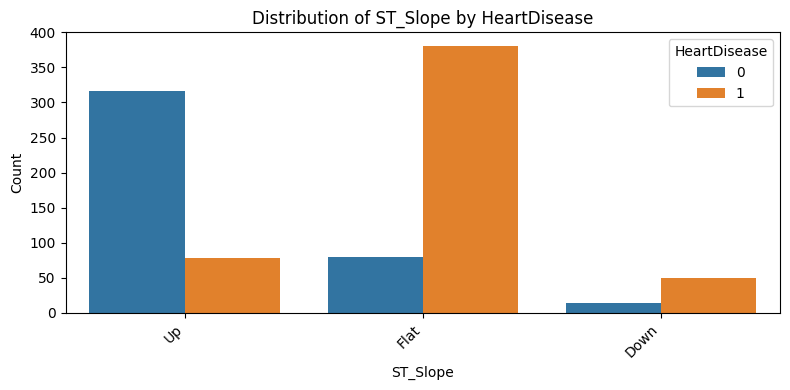

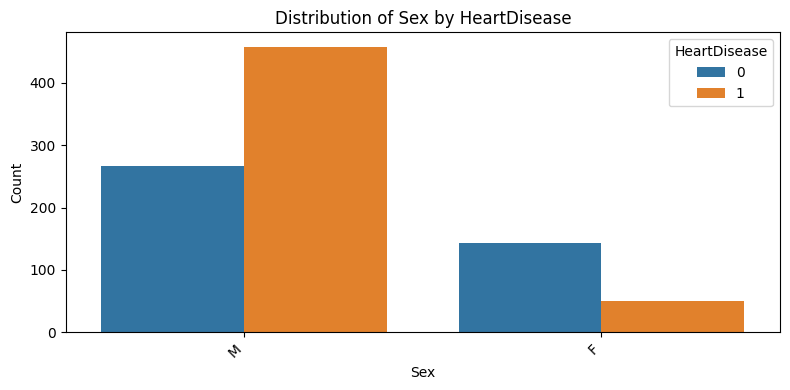

In [9]:
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column, hue='HeartDisease')
    plt.title(f'Distribution of {column} by HeartDisease')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title = 'HeartDisease')
    plt.tight_layout()
    plt.show()

* Most males have a heart disease in the dataset, while is the opposite for females.
* The ASY chest pain shows a big correlation with heart disease.
* Flat ST Slope also has a good correlation with heart disease.

In [10]:
# What percentage of patients with heart disease are male and over 50 years old?
HD_male_over50 = df[(df['HeartDisease'] == 1) & (df['Sex'] == 'M') & (df['Age'] > 50)].shape[0] / df.shape[0] * 100
print(f'{HD_male_over50:.2f}% of patients with heart disease are male and over 50 years old.')

# What is the median age of patients who were diagnosed with heart disease?
HD_median_age = df[df['HeartDisease'] == 1]['Age'].median()
print(f'The median age of patients who were diagnosed with heart disease is {HD_median_age:.2f} years old.')

37.47% of patients with heart disease are male and over 50 years old.
The median age of patients who were diagnosed with heart disease is 57.00 years old.


## Data Cleaning


We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values that don't make sense.

In [11]:
print((df['RestingBP']==0).sum())
print((df['Cholesterol']==0).sum())

1
172


In [12]:
#df_clean = df.copy()
#df_clean['Cholesterol'] = df_clean.groupby(['Sex', 'Age'])['Cholesterol'].transform(
    #lambda x: x[x > 0].median() if (x == 0).any() else x
#

In [13]:

df_clean = df.copy()

 #only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())


In [14]:
#df_clean = df_clean.drop(df_clean[df_clean['RestingBP'] == 0].index)
#df_clean = df_clean.drop(df_clean[df_clean['Cholesterol'] == 0].index)

In [15]:
print((df_clean['RestingBP']==0).sum())
print((df_clean['Cholesterol']==0).sum())

0
0


## Feature Selection

Now that we've cleaned our data, we can select features for our model. Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

In [16]:
for i in df_clean.columns:
  print(i)

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


Initially, I will try:
* `Age`
* `Sex`
* `ChestPainType`
* `Cholesterol`
* `RestingBP`

In [17]:
# Converting categorical columns in dummy variables
df_clean = pd.get_dummies(df_clean, drop_first=True)

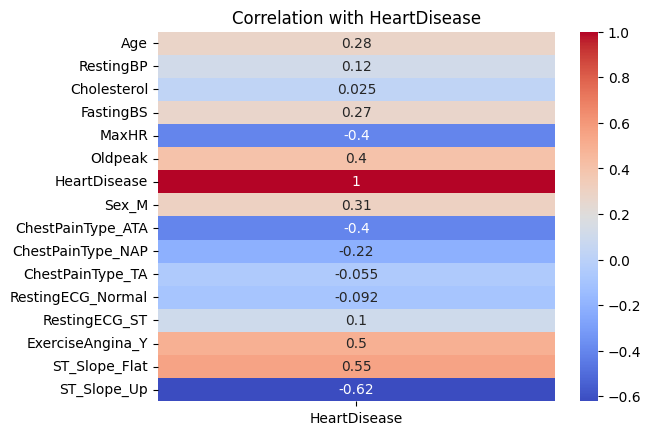

In [18]:
# Calculate the correlation matrix
corr_matrix = df_clean.corr()

# Select the correlations with 'HeartDisease' and reshape to 2D
heart_disease_corr = corr_matrix['HeartDisease'].values.reshape(-1, 1)
# Reshape using .values to get a numpy array before reshaping


sns.heatmap(heart_disease_corr, annot=True, cmap='coolwarm',
            yticklabels=corr_matrix.index, xticklabels=['HeartDisease'])
plt.title('Correlation with HeartDisease')
plt.show()

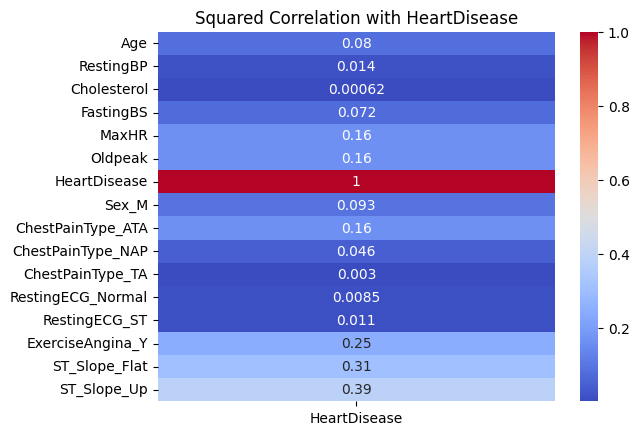

In [19]:
# Calculate the correlation matrix
corr_matrix = (df_clean.corr())**2

# Select the correlations with 'HeartDisease' and reshape to 2D
heart_disease_corr = corr_matrix['HeartDisease'].values.reshape(-1, 1)
# Reshape using .values to get a numpy array before reshaping


sns.heatmap(heart_disease_corr, annot=True, cmap='coolwarm',
            yticklabels=corr_matrix.index, xticklabels=['HeartDisease'])
plt.title('Squared Correlation with HeartDisease')
plt.show()

Using the squared correlation, top 5 correlated features would be:
* `ST_Slope_Up`
* `ST_Slope_Flat`
* `ExerciseAngina_Y`
* `Oldpeak`
* `MaxHR`

Surprisingly, `Cholesterol` is not strongly correlated to `HeartDisease`. We can consider ignoring the feature for now.

## Creating Training and Test Data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Spliting the data with 0.2
X = df_clean.drop(['HeartDisease'], axis=1)
Y = df_clean['HeartDisease']

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
features = ['ST_Slope_Up', 'ST_Slope_Flat' ,'ExerciseAngina_Y' ,'Oldpeak', 'MaxHR'] # Top 5 Squared correlations

In [23]:
for feature in features:
    X_train_feature = X_train[[feature]]  # Note the double brackets to create a DataFrame
    X_val_feature = X_val[[feature]]
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train_feature, Y_train)
    accuracy = knn.score(X_val_feature, Y_val)*100
    print(f'The accuracy of the {feature} with 3 neighbors is {accuracy:.2f}%' )

The accuracy of the ST_Slope_Up with 3 neighbors is 39.13%
The accuracy of the ST_Slope_Flat with 3 neighbors is 76.09%
The accuracy of the ExerciseAngina_Y with 3 neighbors is 67.39%
The accuracy of the Oldpeak with 3 neighbors is 61.41%
The accuracy of the MaxHR with 3 neighbors is 67.39%


### Scaling data and using more than 1 variable in the model

In [24]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])
knn_scaled = KNeighborsClassifier(n_neighbors = 3)
knn_scaled.fit(X_train_scaled, Y_train)
accuracy_scaled = knn_scaled.score(X_val_scaled, Y_val)*100
print(f'The accuracy of the scaled data with 3 neighbors and 5 features together is {accuracy_scaled:.2f}%' )

The accuracy of the scaled data with 3 neighbors and 5 features together is 77.72%


### Hyperparameter Tuning

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(knn, grid_params, scoring = 'accuracy')
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [26]:
grid_search.best_score_*100, grid_search.best_params_

(82.83551356589147, {'metric': 'manhattan', 'n_neighbors': 16})

With optimization was possible to improve 500 bps the accuracy score on the **training set**

In [27]:
from sklearn.metrics import accuracy_score
predictions = grid_search.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 80.07


On the test our accuracy got worst. That may happen because of Overfitting to training data.